In [64]:
#This code uses Topspin pulse program: cpmg. In order for this version of the code to run, experiment should be calibrated
#with the same parameters that allow zg spectrum to be centerd on only doublet.

#It may be possible to change this code to analyze multiple doublets, but have to think more about how chemical shift evolution would affect this, and how to account for correct x axis with multiple peaks.

In [65]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import qutip as qt
import nmrglue as ng
from scipy import integrate
from scipy.optimize import curve_fit
import pulsee.plot as vis
import global_constants as glob
import global_constants as gg
#%matplotlib notebook # commented out cuz it causes my computer to not plot anything
# import pulsee.simulation as sim
# from statistics import median
plt.rcParams['figure.dpi'] = glob.DPI_DISPLAY

plt.rcParams['font.family'] = ['Helvetica']
""" This is to save plots as PDF with editable text (so that Adobe illustrator recognizes text) """
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def combine_to_magnitude(real, imag):
    assert len(real) == len(imag)
    return np.sqrt(real**2 + imag**2)

def get_folder_path(f_n):
    return f"{Bruker_folders_path}/{f_n}/pdata/1"

def t2_func(x, t2, a, b, k, offset):
    return a * np.exp(-x / t2) + b * np.sin(k * x) + offset

def t2_func_exp(x, T2, A, omega, Tj, C, offset1, offset2):
    return (A * np.cos(omega * x + offset2) * np.exp(-x / Tj) + C) * np.exp(-x / T2) + offset1

# Importing Data
#### Select Filepath to CPMG Experiment

In [66]:
cwd = os.getcwd()
Bruker_folders_path = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\Final_Organized_MIT_DATA\2024_12_23-24\NOT_TOMOGRAPHY\T2_Data"

In [67]:
folder_nums = os.listdir(f"{Bruker_folders_path}")
folder_nums_sorted = sorted(folder_nums, key=lambda x: int(''.join(filter(str.isdigit, x))))
print(folder_nums_sorted)
folder_name = folder_nums_sorted[3]
#folder_nums = [str(s) for s in (sorted([int(x) for x in folder_nums]))] # ordering by increasing number value
print(folder_name)

['189', '190', '191', '192', '193', '194', '224']
192


In [68]:
# all_components=True to get both the real & imaginary spectra
all_data = ng.bruker.read_pdata(get_folder_path(folder_name), all_components=True)[1]
all_data = np.array(all_data)
print(all_data.shape)
#this step will not work without "XF2" which makes 2ii file from 2rr
print('Output of this cell should look something like "(2, 1024, 32768)". If it is only 2 numbers long you need to open the Topspin file and run "XF2".')

(2, 1024, 32768)
Output of this cell should look something like "(2, 1024, 32768)". If it is only 2 numbers long you need to open the Topspin file and run "XF2".


# Define Parameters Needed for Calculation

In [69]:
size_of_fid=60
vc_start=0
vc_end=118
vc_linear_step_size=2
nintey_pulse_duration= 2.7E-6 # (s)
oneeighty_pulse_duration= 2.7E-6 # (s)
d20= 0.002 # (s) [d20-180-d20] loop
SPECTRUM_WIDTH = 2000.000  # Hz #for F2 I believe
J = 22  # Hz
#ns 8

# DO NOT NEED FOR CALCULATION
BF1=202.4765750
SFO1=202.4752019
#B_0 = 9  # Tesla
#SPECTRUM_OFFSET = 49697.66
#w_1_Bruker = 242950699.7  # Hz
#w_2_Bruker = 242951648.8  # Hz
#TEMP = 310  # Kelvin
#BF1 = 161.9755930

### Plot Bruker Spectrum Data

In [70]:
all_data = np.flip(all_data, axis=2) #Flip the frequency axis
# Cut off all zero data point
all_data = all_data[:, :size_of_fid, :]   #(-1 python starts at index zero)
all_data.shape
data_mag = combine_to_magnitude(all_data[0], all_data[1])
data_mag.shape

(60, 32768)

In [71]:
#2nd method
# #Auto Phase Data
# complex_data = np.array(all_data[0] + 1j * all_data[1])
# fixed=ng.process.proc_autophase.autops(complex_data, "acme", p0=0.0, p1=0.0)
# real_part = np.real(fixed)
# imaginary_part = np.imag(fixed)

# tt=np.sqrt(real_part**2 + imaginary_part**2)
# tt.shape
# plt.plot(tt[8])

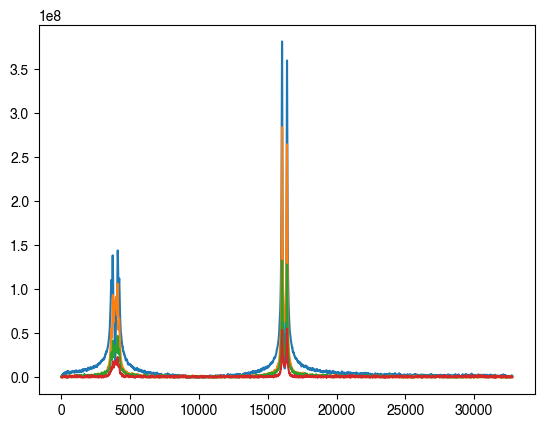

In [72]:
plt.plot(data_mag[0])
plt.plot(data_mag[round(size_of_fid/8)])
plt.plot(data_mag[round(size_of_fid/2)])
plt.plot(data_mag[size_of_fid-1])

# Calculating the frequency axis for the spectrum
According to Bruker's software, the middle of the spectrum should be the experimental larmor frequency (with chemical shift included), and we can set this to 0 Hz. In other words, the frequency axis range is: (-spectrum_width/2, spectrum/2), with 0 in the middle, and left peak should occur at -$J$ and right peak at $J$

In [73]:
freqs = np.linspace(-SPECTRUM_WIDTH / 2, SPECTRUM_WIDTH / 2, data_mag.shape[1])
L_FREQ = -J / 2
R_FREQ = J / 2

# Plotting a Few Spectra

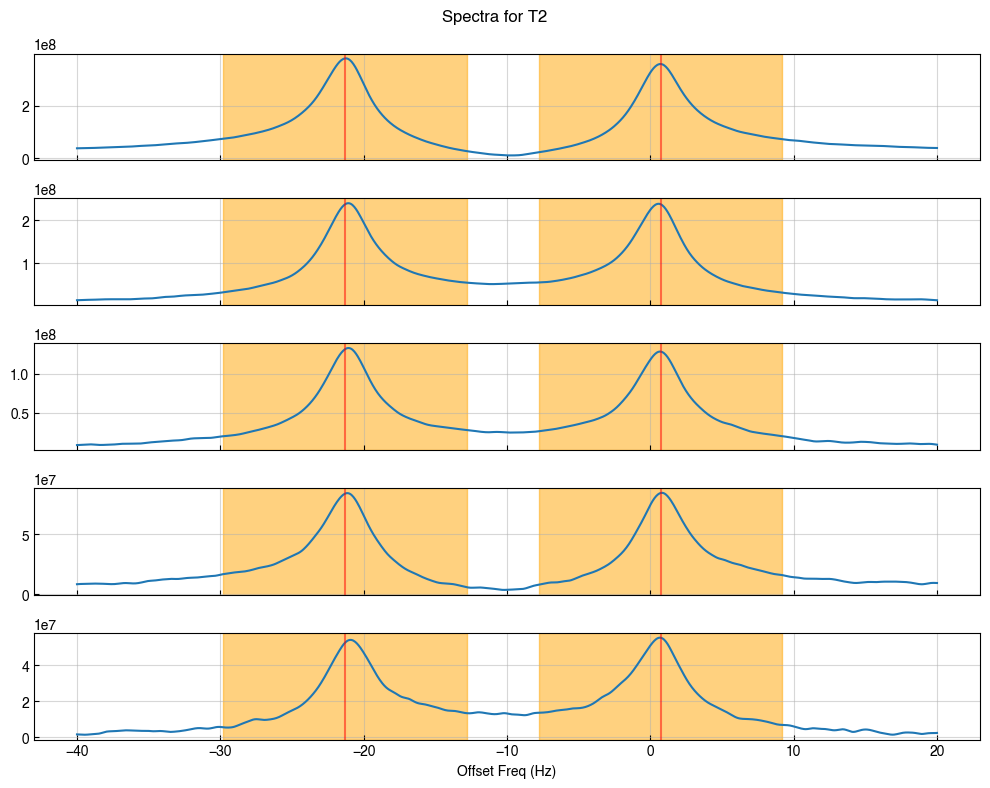

In [74]:

DISPLAY_INDICES = [0,round(size_of_fid/4), round(size_of_fid/2), round(3*size_of_fid/4),  size_of_fid-1]    #Python starts couting at 0, while Bruker starts counting at zero hence the "-1"
N_DISPLAY = len(DISPLAY_INDICES)

INTGR_WIDTH = 17  # in Hz. The width to integrate over.
X_LIMS_DISPLAY = [-40, 20]
i_L = np.absolute(freqs - X_LIMS_DISPLAY[0]).argmin()
i_R = np.absolute(freqs - X_LIMS_DISPLAY[1]).argmin()

fig, axs = plt.subplots(N_DISPLAY, 1, figsize=(2 * N_DISPLAY, 8), sharex=True, sharey=False)

# Making an offset so the red lines visually line up with the peaks
intgr_offset = -J/2+.7
intgr_centers = (L_FREQ + intgr_offset, R_FREQ + intgr_offset)

for i_axis, i_spectrum in enumerate(DISPLAY_INDICES):
    # plot the spectrum
    ax = axs[i_axis]
    ax.plot(freqs[i_L : i_R + 1], data_mag[i_spectrum][i_L : i_R + 1])
    ax.grid(alpha=0.5)
    ax.set(xlabel='Offset Freq (Hz)')
    ax.label_outer()
    ax.tick_params(direction='in')
    
    ax.axvline(intgr_centers[0], color='r', alpha=0.5)
    ax.axvline(intgr_centers[1], color='r', alpha=0.5)
    ax.axvspan(intgr_centers[0] - INTGR_WIDTH / 2, intgr_centers[0] + INTGR_WIDTH / 2, color='orange', alpha=0.5)
    ax.axvspan(intgr_centers[1] - INTGR_WIDTH / 2, intgr_centers[1] + INTGR_WIDTH / 2, color='orange', alpha=0.5)
    
    # plot integration lines
    

fig.suptitle('Spectra for T2')
fig.tight_layout()
plt.show()

# Integrate each spectrum to get the peak intensities
1. Integrate sample points using (`scipy.integrate.trapezoid`)
2. Integrate sample points using (`scipy.integrate.simpson`)

In [75]:
def integrate_doublet(spectrum):
    i_L_lo = np.abs(freqs - (intgr_centers[0] - INTGR_WIDTH / 2)).argmin()
    i_L_hi = np.abs(freqs - (intgr_centers[0] + INTGR_WIDTH / 2)).argmin()
    i_R_lo = np.abs(freqs - (intgr_centers[1] - INTGR_WIDTH / 2)).argmin()
    i_R_hi = np.abs(freqs - (intgr_centers[1] + INTGR_WIDTH / 2)).argmin()
    
    area_L = integrate.trapezoid(spectrum[i_L_lo : i_L_hi])
    area_R = integrate.trapezoid(spectrum[i_R_lo : i_R_hi])
    return area_L, area_R

In [76]:
areas_all = [integrate_doublet(spectrum) for spectrum in data_mag]
areas_all = np.array(areas_all)
areas_all.shape

(60, 2)

In [77]:
areas_left = areas_all[:, 0]
areas_right = areas_all[:, 1]

# Simple Plot and Fit

Calculating the tau times from pulse sequence parameters. vc(1) is looped over accordong to a seperatly defiined vclist. vc list values are always even so detected signal is never inverted.


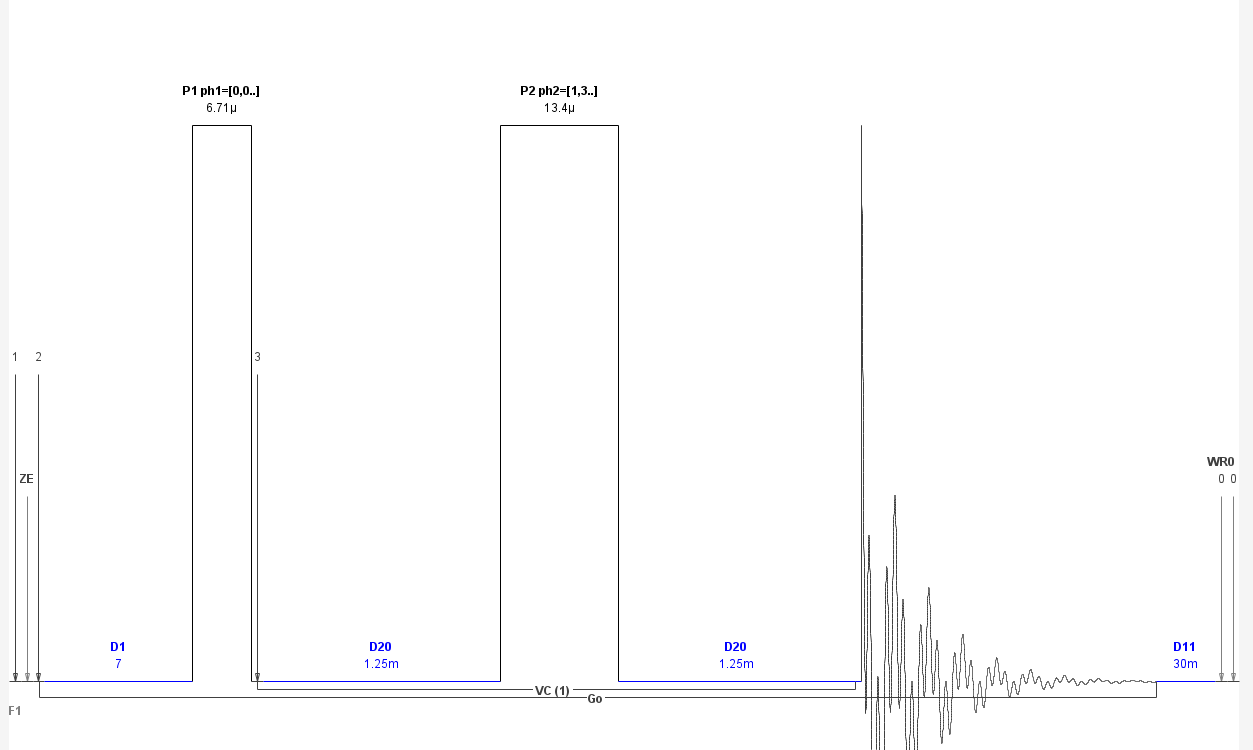

In [78]:
wait_times = []
for i in range(vc_start, vc_end+2, vc_linear_step_size):                          #Stop value not included, hence "+2"
    time = nintey_pulse_duration + (oneeighty_pulse_duration + 2*d20) * i    
    wait_times.append(time)

wait_times = np.array(wait_times)
wait_times

#should start time start at beginning, middle, or end of first pulse?

array([2.700000e-06, 8.008100e-03, 1.601350e-02, 2.401890e-02,
       3.202430e-02, 4.002970e-02, 4.803510e-02, 5.604050e-02,
       6.404590e-02, 7.205130e-02, 8.005670e-02, 8.806210e-02,
       9.606750e-02, 1.040729e-01, 1.120783e-01, 1.200837e-01,
       1.280891e-01, 1.360945e-01, 1.440999e-01, 1.521053e-01,
       1.601107e-01, 1.681161e-01, 1.761215e-01, 1.841269e-01,
       1.921323e-01, 2.001377e-01, 2.081431e-01, 2.161485e-01,
       2.241539e-01, 2.321593e-01, 2.401647e-01, 2.481701e-01,
       2.561755e-01, 2.641809e-01, 2.721863e-01, 2.801917e-01,
       2.881971e-01, 2.962025e-01, 3.042079e-01, 3.122133e-01,
       3.202187e-01, 3.282241e-01, 3.362295e-01, 3.442349e-01,
       3.522403e-01, 3.602457e-01, 3.682511e-01, 3.762565e-01,
       3.842619e-01, 3.922673e-01, 4.002727e-01, 4.082781e-01,
       4.162835e-01, 4.242889e-01, 4.322943e-01, 4.402997e-01,
       4.483051e-01, 4.563105e-01, 4.643159e-01, 4.723213e-01])

In [79]:
guesses = guesses = [2.36027542e-01, 3.90000000e+09, 1.39811056e+02, 1.00000000e+02,
                     4.20804471e+10, 7.89557638e+08, 1.79893616e+00]

# T2, A, omega, Tj, C, offset1, offset2
#(A * np.cos(omega * x + offset2) * np.exp(-x / Tj) + C) * np.exp(-x / T2) + offset1

lower_bounds = [0, 3.9e9, 100, 100, -1e12, -1e12, -2 * np.pi]
upper_bounds = [1, 1e12, 400, 1000, 1e12, 1e12, 2 * np.pi]

popt_left, pcov_left = curve_fit(t2_func_exp, wait_times, areas_left, p0=guesses, bounds=(lower_bounds, upper_bounds))
popt_right, pcov_right = curve_fit(t2_func_exp, wait_times, areas_right, p0=guesses,bounds=(lower_bounds, upper_bounds))

t2_left, t2_left_err = popt_left[0], np.sqrt(pcov_left[0, 0])
t2_right, t2_right_err = popt_right[0], np.sqrt(pcov_right[0, 0])

PLUS_MINUS = u'\u00b1'
display(popt_left)
display(popt_right)
print(f"Left peak: T2 = {t2_left: .3f} {PLUS_MINUS} {t2_left_err:.3f}")
print(f"Right peak: T2 = {t2_right: .3f} {PLUS_MINUS} {t2_right_err:.3f}")

array([2.35564180e-01, 3.90000000e+09, 1.39837147e+02, 1.00000000e+02,
       4.21090596e+10, 8.22669328e+08, 1.75712639e+00])

array([2.33160578e-01, 3.90000000e+09, 1.38630404e+02, 1.00000000e+02,
       4.13357828e+10, 1.04788574e+09, 1.98614217e+00])

Left peak: T2 =  0.236 ± 0.008
Right peak: T2 =  0.233 ± 0.006


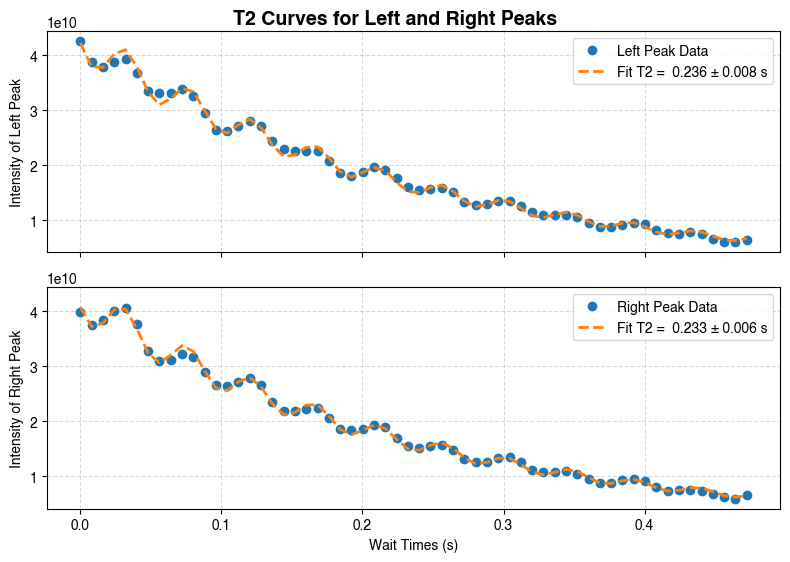

In [80]:
# Create the figure and axis with adjusted layout for publication
fig_t2, axs_t2 = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)

# Plot data points with a distinct color and marker size for clarity
axs_t2[0].plot(wait_times, areas_left, 'o', markersize=6, label='Left Peak Data')
axs_t2[1].plot(wait_times, areas_right, 'o', markersize=6, label='Right Peak Data')

# Plot fit lines with higher contrast against the data points
axs_t2[0].plot(wait_times, t2_func_exp(wait_times, *popt_left), linestyle='--', linewidth=2,
               label=f"Fit T2 = {t2_left: .3f} {PLUS_MINUS} {t2_left_err:.3f} s")
axs_t2[1].plot(wait_times, t2_func_exp(wait_times, *popt_right), linestyle='--', linewidth=2,
               label=f"Fit T2 = {t2_right: .3f} {PLUS_MINUS} {t2_right_err:.3f} s")

# Set labels and increase font size for publication readability
axs_t2[0].set_ylabel("Intensity of Left Peak")
axs_t2[1].set_ylabel("Intensity of Right Peak")
axs_t2[1].set_xlabel("Wait Times (s)")

# Set legend positions and adjust font size
axs_t2[0].legend()
axs_t2[1].legend()

# Set title and adjust spacing
fig_t2.suptitle('T2 Curves for Left and Right Peaks', fontsize=14, weight='bold', y=0.93)

# Enable grid with a subtle color and style
[ax.grid(color='gray', linestyle='--', alpha=0.3) for ax in axs_t2]

# Add a horizontal line at y=70 for both subplots
#axs_t2[0].axvline(x=0.09167371989191499, color='r', linestyle='--', label="y = 70")
#axs_t2[0].axvline(x=2*0.09167371989191499, color='r', linestyle='--', label="y = 70")
#axs_t2[1].axvline(x=0.09167371989191499, color='r', linestyle='--', label="y = 70")

# Optimize layout for spacing and readability
# fig_t2.tight_layout(pad=2.0)
fig_t2.tight_layout()
# Show the plot
plt.show()

fig_t2.savefig("t2_curves_high_dpi.png", dpi=900, bbox_inches='tight')

# T2 values for simple fit:

In [81]:
print(f"T2 for left peak: {popt_left[0]}")
print(f"T2 for right peak: {popt_right[0]}")

T2 for left peak: 0.23556417951239028
T2 for right peak: 0.23316057785596708


In [82]:
print(f"Left angular frequency (omega) = {popt_left[2]} (rad/sec.)")
print(f"Left f = {popt_left[2] / (2 * np.pi)} (Hz)")
print(f"left period = {(2 * np.pi)/popt_left[2]} (s)")
print(f"Right omega = {popt_right[2]} (rad/sec.)")
print(f"Right f = {popt_right[2] / (2 * np.pi)} (Hz)")
print(f"Right period = {(2 * np.pi)/popt_right[2]} (s)")
#J is 1/4 of the frequency
print(f"Left J = {2 * popt_left[2] / (2 * np.pi)} (Hz)")
print(f"left J = {1/(2*(2 * np.pi)/(4*popt_left[2]))} (Hz)")

print(f"Right J = {2 * popt_right[2] / (2 * np.pi)} (Hz)")
print(f"Right J = {1/(2*(2 * np.pi)/(4*popt_right[2]))} (Hz)")

Left angular frequency (omega) = 139.83714742525171 (rad/sec.)
Left f = 22.255773240598916 (Hz)
left period = 0.044932161609905465 (s)
Right omega = 138.63040417594436 (rad/sec.)
Right f = 22.063714087428874 (Hz)
Right period = 0.045323284920999074 (s)
Left J = 44.51154648119783 (Hz)
left J = 44.51154648119783 (Hz)
Right J = 44.12742817485775 (Hz)
Right J = 44.12742817485775 (Hz)


# Sinusoidal Exponential Decay Fit

In [83]:
guesses1 =  [1.22184639e-01, 2.70285667e+02, 1.95748057e+06, 1.07246873e+02, 2.84366042e-02, 3.57032473e+06, 2.04748395e+00]
# T2, I0, A, omega, Tj, C, offset1
lower_bounds1 = [0 , 0, 0, 0, 0 , 0, 0]
upper_bounds1 = [5, 1e10, 1e10, 1e10, 1e10 , 1e10, 1e10]
#T2 is less than 5s
#sample good fit [1.22184639e-01, 2.70285667e+02, 1.95748057e+06, 1.07246873e+02, 2.84366042e-02, 3.57032473e+06, 2.04748395e+00]

popt_left1, pcov_left1 = curve_fit(t2_func_exp, wait_times, areas_left, p0=guesses1, bounds=(lower_bounds1, upper_bounds1))
popt_right1, pcov_right1 = curve_fit(t2_func_exp, wait_times, areas_right, p0=guesses1, bounds=(lower_bounds1, upper_bounds1))

display(popt_left1)
display(popt_right1)

array([4.06287237e-01, 3.14162602e+08, 1.91574919e+06, 7.65332275e+09,
       1.00000000e+10, 9.99999914e+09, 9.29525325e-01])

array([3.89265526e-01, 1.55858233e+09, 2.36699144e+07, 3.54813945e+09,
       1.00000000e+10, 1.00000000e+10, 4.91904378e+01])

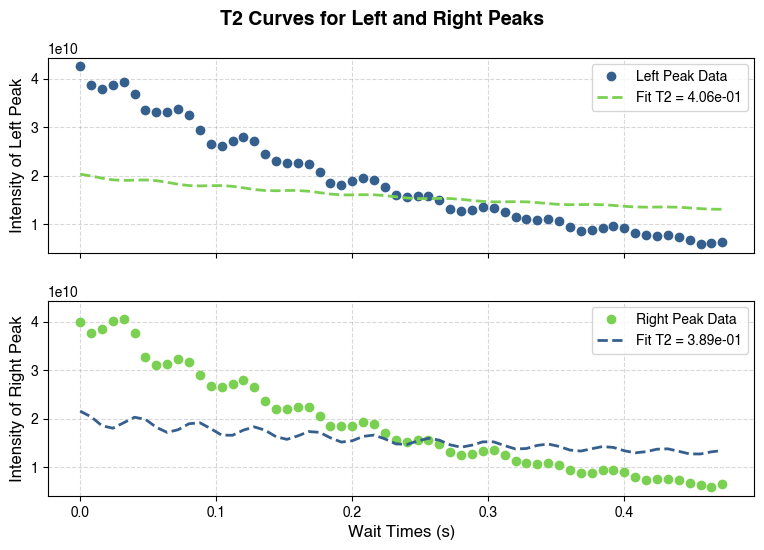

In [84]:
# Access the Viridis colormap in a version-compatible way
viridis = plt.get_cmap('viridis')

# Create the figure and axis with adjusted layout for publication
fig_t2, axs_t2 = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)

# Plot data points with a distinct color and marker size for clarity
axs_t2[0].plot(wait_times, areas_left, 'o', color=viridis(0.3), markersize=6, label='Left Peak Data')
axs_t2[1].plot(wait_times, areas_right, 'o', color=viridis(0.8), markersize=6, label='Right Peak Data')

# Plot fit lines with higher contrast against the data points
axs_t2[0].plot(wait_times, t2_func_exp(wait_times, *popt_left1), color=viridis(0.8), linestyle='--', linewidth=2, 
               label=f"Fit T2 = {popt_left1[0]:.2e}")
axs_t2[1].plot(wait_times, t2_func_exp(wait_times, *popt_right1), color=viridis(0.3), linestyle='--', linewidth=2, 
               label=f"Fit T2 = {popt_right1[0]:.2e}")

# Set labels and increase font size for publication readability
axs_t2[0].set_ylabel("Intensity of Left Peak", fontsize=12)
axs_t2[1].set_ylabel("Intensity of Right Peak", fontsize=12)
axs_t2[1].set_xlabel("Wait Times (s)", fontsize=12)

# Set legend positions and adjust font size
axs_t2[0].legend(loc='upper right', fontsize=10)
axs_t2[1].legend(loc='upper right', fontsize=10)

# Set title and adjust spacing
fig_t2.suptitle('T2 Curves for Left and Right Peaks', fontsize=14, weight='bold', y=0.93)

# Enable grid with a subtle color and style
[ax.grid(color='gray', linestyle='--', alpha=0.3) for ax in axs_t2]

# Optimize layout for spacing and readability
fig_t2.tight_layout(pad=2.0)

plt.savefig('T2_5_7_2024.pdf', format='pdf')

# Show the plot
plt.show()


# T2 values for Sinusoidal Exponential Decay fit:

In [85]:
print(f"T2 for left peak: {popt_left1[0]}")
print(f"T2 for right peak: {popt_right1[0]}")

T2 for left peak: 0.40628723717876475
T2 for right peak: 0.3892655259937333


In [86]:
print(f"Omega for left peak: {popt_left1[3]}")
print(f"Omega for right peak: {popt_right1[3]}")
j_from_fitting=popt_left1[3]/(2*np.pi)
print(f'The J calculated from fitting = {j_from_fitting}Hz. The J inputed at the beginning was = {J}Hz ')

print(f"Tj for left peak: {popt_left1[4]}")
print(f"Tj for right peak: {popt_right1[4]}")

Omega for left peak: 7653322752.071466
Omega for right peak: 3548139453.3051596
The J calculated from fitting = 1218064147.069842Hz. The J inputed at the beginning was = 22Hz 
Tj for left peak: 9999999999.971405
Tj for right peak: 9999999999.999998


In [87]:
perr = np.sqrt(np.diag(pcov_left1))
perr
print(f"T2 Error 1 standard deviation left peak: {perr[0]}")
print(f"J coupling Error 1 standard deviation left peak: {perr[0]/(2*np.pi)}")

T2 Error 1 standard deviation left peak: 1.6586750269590271
J coupling Error 1 standard deviation left peak: 0.26398632952361195


In [88]:
perr

array([1.65867503e+00, 2.78377088e+09, 7.47128403e+01, 7.13316791e-06,
       2.15893915e+10, 2.38708149e+10, 1.46005386e+01])

In [89]:
'''
To Do
-not sure how to get errors bars on each of the data points
'''

'\nTo Do\n-not sure how to get errors bars on each of the data points\n'

In [91]:
print(wait_times[0])
print(wait_times[round(size_of_fid/4)])
print(wait_times[round(size_of_fid/2)])
print(wait_times[round(3*size_of_fid/4)])
print(wait_times[round(size_of_fid-1)])

2.7e-06
0.12008369999999999
0.24016469999999998
0.3602457
0.4723213
